In [1]:
import numpy as np
import matplotlib.pyplot as plt # data visualization library

If possible, update your sklearn version to 1.5.2 to reduce variance in the versions.

In [2]:
# The scikit-learn version is 1.5.2.

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.5.2.


In [3]:
import sklearn
print('The numpy version is {}.'.format(np.__version__))

The numpy version is 2.1.3.


# MNIST ANN

In [4]:
import torch
import numpy as np
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
device

'cpu'

In [5]:
# hyper parameters to play with
dropout_1 = 0.1
dropout_2 = 0.1
lr = 0.01
momentum = 0.9
weight_decay = 5e-4
batch_size = 128
epochs = 5

## Define the network architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F

HAS_PRINTED = False

# The embedding architecture returns the
# output of the penultimate layer
class ResBlock(nn.Module):
    def __init__(self, in_size:int, out_size:int, kernel_size:int, groups=1):
        super().__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size, padding="same", groups=groups)
        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size, padding="same", groups=groups)
        self.skip_connection = nn.Identity() if in_size==out_size else nn.Conv2d(in_size, out_size, kernel_size=1, padding="same")
        # normalization layers
        self.norm1 = nn.BatchNorm2d(in_size)
        self.norm2 = nn.BatchNorm2d(out_size)
        # activation functions
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()


    def forward(self, x: torch.Tensor)->torch.Tensor:
        h = self.conv1(self.act1(self.norm1(x)))
        h = self.conv2(self.act2(self.norm2(h)))
        x = self.skip_connection(x)
        return x + h


class Embed(nn.Module):
    def __init__(self, embedding_dim:int, dropout1:float=dropout_1, dropout2:float=dropout_2):
        super(Embed, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=5, padding="same")
        # res blocks
        self.block1 = ResBlock(32, 32, 3, groups=2)
        self.block2 = ResBlock(32, 32, 3, groups=2)
        self.block3 = ResBlock(32, 64, 3, groups=4)
        self.block4 = ResBlock(64, 64, 3, groups=4)
        # pooling layer
        self.pool = nn.MaxPool2d(2)
        # normalization layers
        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(32)
        self.norm3 = nn.BatchNorm1d(64)
        # linear layers
        self.fc1   = nn.Linear(64, 128)
        self.fc2   = nn.Linear(128, embedding_dim)
        # dropout
        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)


    def forward(self, x:torch.Tensor)->torch.Tensor:
        global HAS_PRINTED
        out = F.relu(self.norm1(self.conv(x)))   # convolution to prepare for res blocks
        if not HAS_PRINTED:
          print(f"tensor shape 1: {out.shape=}")
        out = self.block2(self.block1(out))  # first set of res blocks
        if not HAS_PRINTED:
          print(f"tensor shape 2: {out.shape=}")
        out = self.norm2(self.pool(out))  # pooling
        if not HAS_PRINTED:
          print(f"tensor shape 3: {out.shape=}")
        out = self.block4(self.block3(out))  # second set of res blocks
        if not HAS_PRINTED:
          print(f"tensor shape 4: {out.shape=}")
        out = torch.mean(out, dim=(-1, -2))  # average over spatial dimensions
        out = self.norm3(out)  # batch norm before fully connected part
        if not HAS_PRINTED:
          print(f"tensor shape 5: {out.shape=}")

        HAS_PRINTED = True

        # fully connected part:
        out = self.dropout1(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)

        return out

class Net(nn.Module):
    def __init__(self,embedding_dim, classifier):
        super(Net, self).__init__()
        self.embed = Embed(embedding_dim=embedding_dim)
        self.classifier = classifier

    def forward(self, x):
        out = self.embed(x)
        out = self.classifier(out)
        return out

    def conf(self,x):
        out = self.embed(x)
        return F.softmax(self.classifier(out),dim=1)

## Load the data: the first four MNIST classes

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#classes = ('0', '1', '2', '3', '4', '5')
c=10

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=trans)

# Select only some classes
idx = train_data.targets < c
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)


testset = datasets.MNIST(root='./data', train=False, download=True, transform=trans)
# Select only some classes
idx = testset.targets < c
testset.targets = testset.targets[idx]
testset.data = testset.data[idx]
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

==> Preparing data..


## Implementation of the training and testing

In [8]:
import time
def train_epoch(net, criterion, optimizer, trainloader, verbose=False):
    train_loss, correct, conf = 0, 0, 0
    start_time=time.time()
    net.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Set the gradient to zero
        optimizer.zero_grad()
        # Do the forward pass
        logits = net(inputs)
        loss = criterion(logits, targets)
        if verbose:
            print("loss:",loss.item())
        # Do the backward pass
        loss.backward()
        # Do a gradient descent step
        optimizer.step()

        with torch.no_grad(): #Disable gradient tracking and compute some statistics
            train_loss += loss.item()
            y_probs = F.softmax(logits, dim=1)
            confBatch, predicted = y_probs.max(1)
            correct += predicted.eq(targets).sum().item()
            conf+=confBatch.sum().item()
    execution_time = (time.time() - start_time)
    n=len(trainloader.dataset)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f | time (s): %.2f'% (train_loss/len(trainloader), 100.*correct/n, correct, n, 100*conf/n, execution_time))
    return (100.*correct/n, 100*conf/n)

def test_acc(net, criterion, data_loader):
    net.eval()
    test_loss, correct, conf, total = 0,0,0,0
    with torch.no_grad(): # disable gradient tracking
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            logits = net(inputs)
            loss = criterion(logits, targets)

            test_loss += loss.item()
            y_probs = F.softmax(logits, dim=1)
            confBatch, predicted = y_probs.max(1)
            correct += predicted.eq(targets).sum().item()
            conf+=confBatch.sum().item()
    n=len(data_loader.dataset)
    print('Loss: %.3f | Acc: %.3f%% (%d/%d) | Conf %.2f'% (test_loss/max(len(data_loader),1), 100.*correct/n, correct, n, 100*conf/n))
    return (100.*correct/n, 100*conf/n)

## Create the model and perform the optimization for 10 epochs

In [9]:
d=2
# Model
print('==> Building model..')
classifier = nn.Linear(d, c, bias=True)
net = Net(embedding_dim=d, classifier=classifier)
net = net.to(device)

criterion = nn.CrossEntropyLoss()

sgd = torch.optim.SGD([{'params': net.parameters()},],
                lr=lr, momentum=momentum, weight_decay=weight_decay)

==> Building model..


In [10]:
import os
for epoch in range(epochs):
    print('\nEpoch: %d' % epoch)
    train_epoch(net, criterion, sgd, trainloader)
    (acc,conf) = test_acc(net,criterion, testloader)

print('Saving..')
state = {'net': net.state_dict(),'acc': acc}
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, './checkpoint/net.t7')



Epoch: 0
tensor shape 1: out.shape=torch.Size([128, 32, 28, 28])
tensor shape 2: out.shape=torch.Size([128, 32, 28, 28])
tensor shape 3: out.shape=torch.Size([128, 32, 14, 14])
tensor shape 4: out.shape=torch.Size([128, 64, 14, 14])
tensor shape 5: out.shape=torch.Size([128, 64])
Loss: 0.774 | Acc: 73.838% (44303/60000) | Conf 65.09 | time (s): 120.27
Loss: 0.879 | Acc: 72.390% (7239/10000) | Conf 75.14

Epoch: 1
Loss: 0.275 | Acc: 93.770% (56262/60000) | Conf 88.91 | time (s): 135.03
Loss: 0.206 | Acc: 95.170% (9517/10000) | Conf 92.15

Epoch: 2
Loss: 0.195 | Acc: 95.732% (57439/60000) | Conf 92.77 | time (s): 132.24
Loss: 0.287 | Acc: 92.600% (9260/10000) | Conf 89.91

Epoch: 3
Loss: 0.148 | Acc: 96.708% (58025/60000) | Conf 94.29 | time (s): 124.82
Loss: 0.121 | Acc: 97.210% (9721/10000) | Conf 95.76

Epoch: 4
Loss: 0.123 | Acc: 97.192% (58315/60000) | Conf 95.31 | time (s): 129.55
Loss: 0.166 | Acc: 95.990% (9599/10000) | Conf 93.83
Saving..


## Plot the latent space representations

In [11]:
# Load the saved net
classifier = nn.Linear(d, c,bias=True)
net = Net(embedding_dim=d, classifier=classifier)
checkpoint = torch.load("checkpoint/net.t7",map_location='cpu')
net.load_state_dict(checkpoint['net'])
net.eval()
print('ACC:\t',checkpoint['acc'])

ACC:	 95.99


C:\Users\20210865\AppData\Local\Temp\ipykernel_52360\4236932101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint/net.t7",map_location=

In [12]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def scatter_pictures(inputs, outputs, samples=30):
    zoom = 0.7

    for j in range(min(inputs.shape[0],samples)):
        image = inputs[j,:,:,:].squeeze()
        im = OffsetImage(image, cmap="gray",zoom=zoom)
        ab = AnnotationBbox(im, (outputs[j,0], outputs[j,1]), xycoords='data', frameon=False, alpha=0.5)
        ax.add_artist(ab)

In [13]:
import matplotlib.pyplot as plt
def plot_conf(conf, show_class_assignment=False, x_max=20, y_max=20, x_min=-1, y_min=-1):
    x = np.arange(x_min, x_max, 0.05)
    y = np.arange(y_min, y_max, 0.05)

    xx, yy = np.meshgrid(x, y)
    X = np.array([xx,yy]).reshape(2,x.shape[0]*y.shape[0]).T
    Z = conf(torch.from_numpy(X).float()).t()
    Z = Z.reshape(-1,y.shape[0],x.shape[0]).cpu().detach().numpy()
    if show_class_assignment:
        h = plt.contourf(x,y,Z.argmax(axis=0),cmap='magma')
    else:
        h = plt.contourf(x,y,Z.max(axis=0),cmap='magma')
        plt.clim(0, 1)
        cb = plt.colorbar()
        cb.set_label('Confidence')
    plt.axis('scaled')

C:\Users\20210865\AppData\Local\Temp\ipykernel_52360\3817812508.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.arange(x_min, x_max, 0.05)
C:\Users\20210865\AppData\Local\Temp\ipykernel_52360\3817812508.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y = np.arange(y_min, y_max, 0.05)


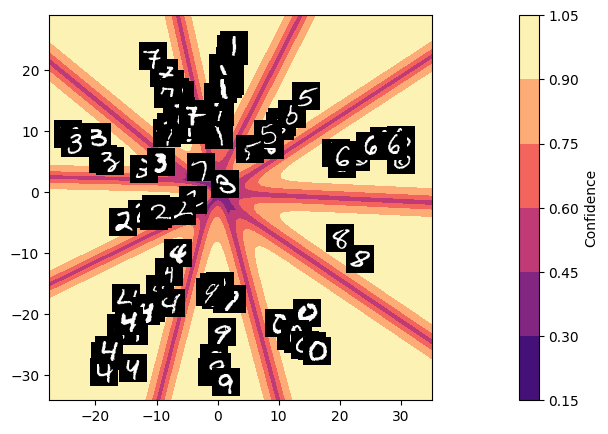

In [14]:
inputs, targets = next(iter(testloader)) #load a batch
outputs = net.embed(inputs).detach()
fig, ax = plt.subplots(figsize=(8,5))
plot_conf((lambda x: torch.softmax(net.classifier(x),dim=1)), x_max =max(outputs[:,0])+5, y_max =max(outputs[:,1])+5, x_min =min(outputs[:,0])-3, y_min =min(outputs[:,1])-3)
scatter_pictures(inputs, outputs,samples=100)

## Plot Representations of out-of-distribution data

In [15]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
c=10

# Data
print('==> Preparing data..')
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=trans)
trainloader_fashion = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)


testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=trans)
testloader_fashion = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

==> Preparing data..


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.23MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 1.17MB/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 5.63MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.22MB/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



C:\Users\20210865\AppData\Local\Temp\ipykernel_52360\3817812508.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.arange(x_min, x_max, 0.05)
C:\Users\20210865\AppData\Local\Temp\ipykernel_52360\3817812508.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y = np.arange(y_min, y_max, 0.05)


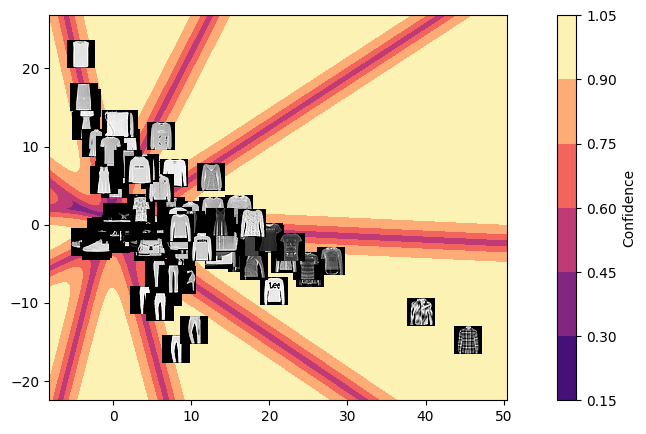

In [16]:
inputs, targets = next(iter(testloader_fashion))
outputs = net.embed(inputs).detach()
fig, ax = plt.subplots(figsize=(8,5))
plot_conf((lambda x: torch.softmax(net.classifier(x),dim=1)), x_max =max(outputs[:,0])+5, y_max =max(outputs[:,1])+5, x_min =min(outputs[:,0])-3, y_min =min(outputs[:,1])-3)
scatter_pictures(inputs, outputs,samples=100)